In [73]:
import numpy as np 
from scipy.stats import zipf
import matplotlib.pyplot as plt
from numba import jit
from tqdm.auto import trange
import seaborn as sns
from seaborn import kdeplot 

plt.style.use('fast')

<Axes: ylabel='Density'>

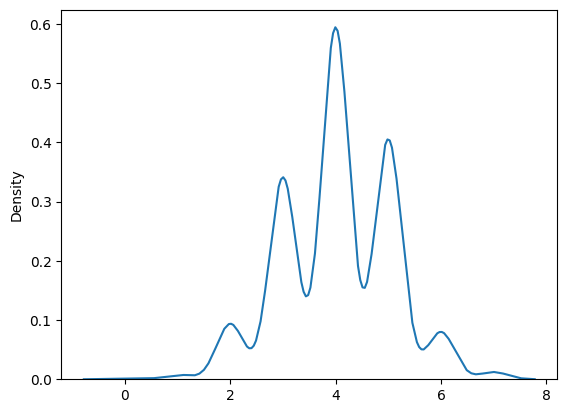

In [241]:
kdeplot(np.round(np.random.normal(4, 1, 1000)), label = 'initial lengths')

In [262]:
# @torch.compile
def model(selection, mutation_rate, zipf = 1.5, detailed = False):
    n_generations = 20
    n_encounters = 5000
    n_meanings = 5000
    n_agents = 5000

    # lognormal parameters
    mu = 1
    sigma = 0.4

    corr_coeffs = []

    freq_meanings = np.random.zipf(zipf, size=n_meanings)
    freq_meanings = freq_meanings / np.sum(freq_meanings)
    word_meaning_matrix = np.round(np.random.lognormal(mu, sigma, (n_agents, n_meanings)))

    for _ in range(n_generations):
        for _ in range(n_encounters):
            agent1, agent2 = np.random.choice(n_agents, 2, replace=False)
            meaning = np.random.choice(n_meanings, p=freq_meanings)
            wordform1, wordform2 = word_meaning_matrix[agent1, meaning], word_meaning_matrix[agent2, meaning]

            if np.random.rand() <= selection:
                word_meaning_matrix[agent2, meaning] = np.minimum(wordform1, wordform2)
                word_meaning_matrix[agent1, meaning] = np.minimum(wordform1, wordform2)
            else:
                if np.random.rand() < 0.5:
                    word_meaning_matrix[agent1, meaning] = wordform2
                else:
                    word_meaning_matrix[agent2, meaning] = wordform1

        mutation_agents = np.random.rand(n_agents) < mutation_rate
        mutated_agents = np.where(mutation_agents)[0]
        word_meaning_matrix[mutated_agents, :] = np.round(np.random.lognormal(mu, sigma, 
                                                                            (len(mutated_agents), 
                                                                                n_meanings)))
        corr_coeffs.append(np.corrcoef(freq_meanings, np.mean(word_meaning_matrix, axis=0))[0, 1])
    if detailed:
        return corr_coeffs, word_meaning_matrix, freq_meanings
    else:
        return np.corrcoef(freq_meanings, np.mean(word_meaning_matrix, axis=0))[0, 1]


In [265]:
out, wm_m, freq_m = model(selection=0.01, mutation_rate=0.2, detailed=True)

Text(0, 0.5, 'Mean frequency')

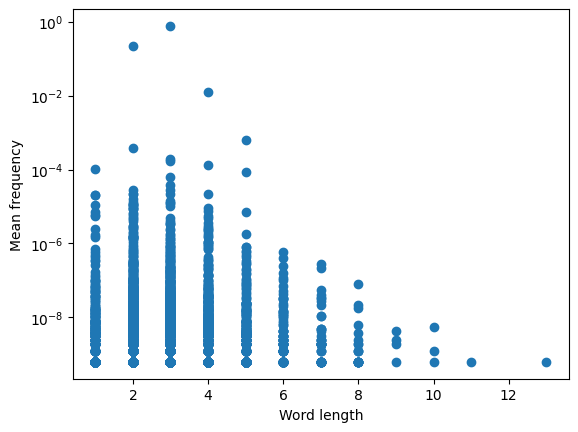

In [271]:
plt.scatter(y = freq_m, x = wm_m[:, 2])
# log y 
plt.yscale('log')
plt.xlabel('Word length')
plt.ylabel('Mean frequency')

Text(0, 0.5, 'Mean frequency')

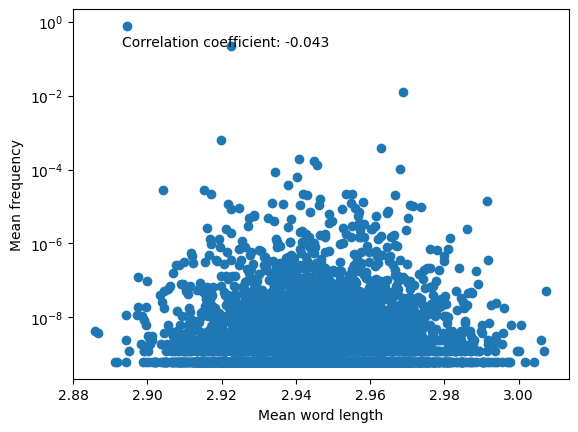

In [269]:
plt.scatter(y = freq_m, x = np.mean(wm_m, axis=0))
# write the correlation coefficient on the plot
plt.text(0.1, 0.9, f'Correlation coefficient: {np.round(out[-1], 3)}', transform=plt.gca().transAxes)
# log y 
plt.yscale('log')
plt.xlabel('Mean word length')
plt.ylabel('Mean frequency')

In [147]:
outs = []
wm_ms = []

for _ in trange(10):
    out, wm_m, _ = model(selection=1, mutation_rate=0.1, detailed=True)
    outs.append(out)
    wm_ms.append(wm_m)

  0%|          | 0/10 [00:00<?, ?it/s]

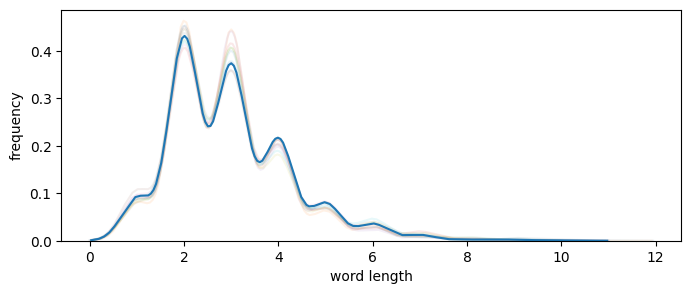

In [184]:
# plot distribution of word lengths
plt.figure(figsize=(8, 3))
# plot the initial distribution of word lengths using seaborn and distplot
# kdeplot(np.random.choice(wm_m.flatten(), size=10000, replace=False), label = 'model lengths')
for _ in wm_ms:
    kdeplot(np.random.choice(_.flatten(), size=1000, replace=False), label = 'model lengths', alpha=0.1)
kdeplot(np.round(np.random.lognormal(1, 0.4, 1000)), label = 'initial lengths')
plt.xlabel('word length')
plt.ylabel('frequency')
# plt.legend()
plt.show()

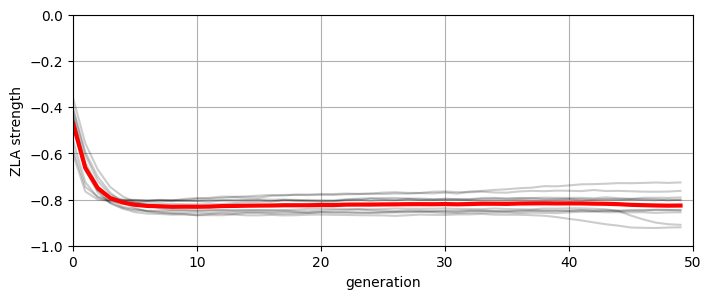

In [161]:
# plot out
plt.figure(figsize=(8, 3))
for _ in outs:
    plt.plot(_, alpha=0.2, color='black')
plt.plot(np.mean(outs, axis=0), color='red', linewidth=3, alpha=1)
plt.xlabel('generation')
plt.ylabel('ZLA strength')
plt.ylim(-1, 0)
plt.xlim(0, 50)
plt.grid()
plt.show()

In [58]:
selections = np.linspace(0.01, 1, 11)
mutation_rates = np.linspace(0.01, 1, 11)

results = np.zeros((len(selections), len(mutation_rates)))

# use tqdm
for i in trange(len(selections)):
    for j in range(len(mutation_rates)):
        results[i, j] = model(selections[i], mutation_rates[j])
        # results[i, j] = np.mean([model(selections[i], mutation_rates[j]) for _ in range(1)])

  0%|          | 0/11 [00:00<?, ?it/s]

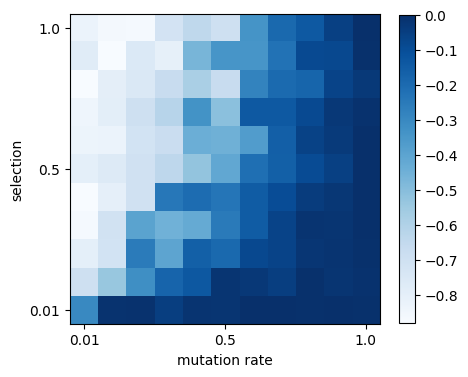

In [61]:
# plot the results as a heatmap
plt.figure(figsize=(5, 5))
plt.imshow(results, cmap='Blues')
plt.xlabel('mutation rate')
plt.ylabel('selection')
# add xticks and yticks but display every 5th value
plt.xticks(np.arange(len(mutation_rates))[::5], np.round(mutation_rates[::5], 2))
plt.yticks(np.arange(len(selections))[::5], np.round(selections[::5], 2))
# reverse y axis ticks
plt.gca().invert_yaxis()
# small colorbar
plt.colorbar(shrink=0.8)
plt.clim(0, -0.8)
plt.show()

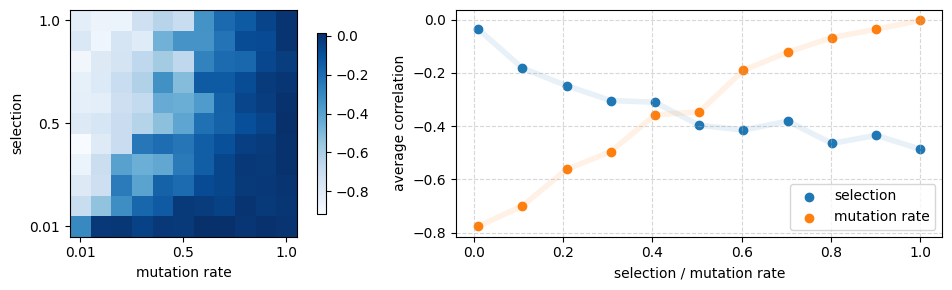

In [152]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'width_ratios': [1, 1.2]})

# heatmap
im = ax1.imshow(results, cmap='Blues')
ax1.set_xlabel('mutation rate')
ax1.set_ylabel('selection')

# add xticks and yticks but display every 5th value
ax1.set_xticks(np.arange(len(mutation_rates))[::5])
ax1.set_xticklabels(np.round(mutation_rates[::5], 2))
ax1.set_yticks(np.arange(len(selections))[::5])
ax1.set_yticklabels(np.round(selections[::5], 2))
# reverse y axis ticks
ax1.invert_yaxis()
# Add colorbar
fig.colorbar(im, ax=ax1, shrink=0.8)

# scatter
ax2.scatter(selections, np.mean(results, axis=1), label='selection')
ax2.plot(selections, np.mean(results, axis=1), alpha=0.1, linewidth=4)
ax2.scatter(mutation_rates, np.mean(results, axis=0), label='mutation rate')
ax2.plot(mutation_rates, np.mean(results, axis=0), alpha=0.1, linewidth=4)
ax2.set_xlabel('selection / mutation rate')
ax2.set_ylabel('average correlation')
# # add horizontal line at 0.1
# ax2.axhline(-0.107, color='black', linestyle='--', alpha=0.5)
# # add horizontal line at 0.5
# ax2.axhline(-0.466, color='black', linestyle='--', alpha=0.5)
ax2.legend()
ax2.grid(alpha=0.5, linestyle='--')

# Adjust vertical alignment
fig.subplots_adjust(bottom=0.2, top=0.8)

# Adjust horizontal alignment
fig.subplots_adjust(wspace=0.1)

plt.tight_layout()
plt.show()


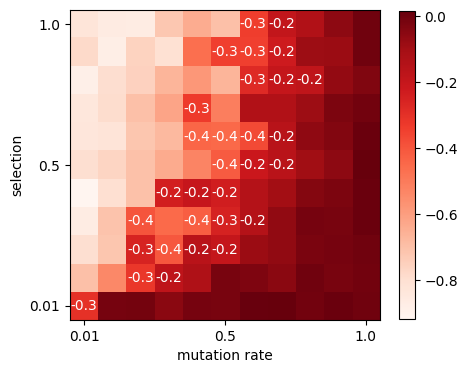

In [117]:
# plot the heatmap, but color cells if they are in between 0.1 and 0.5
plt.figure(figsize=(5, 5))
plt.imshow(results, cmap='Reds')
plt.xlabel('mutation rate')
plt.ylabel('selection')
# add xticks and yticks but display every 5th value
plt.xticks(np.arange(len(mutation_rates))[::5], np.round(mutation_rates[::5], 2))
plt.yticks(np.arange(len(selections))[::5], np.round(selections[::5], 2))
# reverse y axis ticks
plt.gca().invert_yaxis()
# small colorbar
plt.colorbar(shrink=0.8)
# add text to cells which are in between 0.1 and 0.5 with the correlation value rounded to 1 decimal
for i in range(len(selections)):
    for j in range(len(mutation_rates)):
        if  -0.107 >= np.round(results[i, j], 1) >= -0.466:
            plt.text(j, i, np.round(results[i, j], 1), ha='center', va='center', color='white')
plt.show()